In [1]:
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np 

df = pd.read_csv('../datasets/eda_data.csv')

In [2]:
df.columns

Index(['Unnamed: 0', 'Job Title', 'Salary Estimate', 'Job Description',
       'Rating', 'Company Name', 'Location', 'Headquarters', 'Size', 'Founded',
       'Type of ownership', 'Industry', 'Sector', 'Revenue', 'Competitors',
       'hourly', 'employer_provided', 'min_salary', 'max_salary', 'avg_salary',
       'company_txt', 'job_state', 'same_state', 'age', 'python_yn', 'R_yn',
       'spark', 'aws', 'excel', 'sql', 'tableau', 'job_simp', 'seniority',
       'desc_len', 'num_comp'],
      dtype='object')

In [25]:
# Choosing the columns We want to train
df_model = df[['avg_salary','Rating','Size','Type of ownership','Industry','Sector','Revenue','hourly','employer_provided',
             'job_state','same_state','age','python_yn','spark','aws','excel','sql', 'tableau']]
# get dummy data 
df_dum = pd.get_dummies(df_model)
df_dum

,avg_salary,Rating,hourly,employer_provided,same_state,age,python_yn,spark,aws,excel,...,job_state_OR,job_state_PA,job_state_RI,job_state_SC,job_state_TN,job_state_TX,job_state_UT,job_state_VA,job_state_WA,job_state_WI
0,72.0,3.8,0,0,0,47,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,87.5,3.4,0,0,0,36,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,85.0,4.8,0,0,1,10,1,1,0,1,...,0,0,0,0,0,0,0,0,0,0
3,76.5,3.8,0,0,1,55,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,114.5,2.9,0,0,1,22,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
737,84.5,3.9,0,0,0,190,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
738,102.5,4.4,0,0,0,14,1,1,1,0,...,0,0,0,0,1,0,0,0,0,0
739,73.5,2.6,0,0,1,36,0,0,0,1,...,0,1,0,0,0,0,0,0,0,0
740,127.5,3.2,0,0,0,-1,0,0,0,1,...,0,1,0,0,0,0,0,0,0,0


In [35]:
from sklearn.model_selection import train_test_split

X = df_dum.drop('avg_salary', axis =1)
y = df_dum.avg_salary.values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state = 142)

In [36]:
# multiple linear regression 
import statsmodels.api as sm

X_sm = X = sm.add_constant(X)
model = sm.OLS(y,X_sm)
model.fit().summary()

from sklearn.linear_model import LinearRegression, Lasso
from sklearn.model_selection import cross_val_score

lm = LinearRegression()
lm.fit(X_train, y_train)

np.mean(cross_val_score(lm,X_train,y_train, scoring = 'neg_mean_absolute_error', cv = 3))

-21240447724.15254

,alpha,error
5,0.06,-23.242303


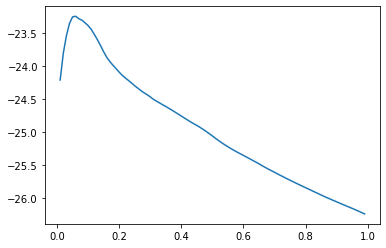

In [21]:
# lasso 
lm_l = Lasso(alpha=.13)
lm_l.fit(X_train,y_train)
np.mean(cross_val_score(lm_l,X_train,y_train, scoring = 'neg_mean_absolute_error', cv= 3))

alpha = []
error = []

for i in range(1,100):
    alpha.append(i/100)
    lml = Lasso(alpha=(i/100))
    error.append(np.mean(cross_val_score(lml,X_train,y_train, scoring = 'neg_mean_absolute_error', cv= 3)))
    
plt.plot(alpha,error)

err = tuple(zip(alpha,error))
df_err = pd.DataFrame(err, columns = ['alpha','error'])
df_err[df_err.error == max(df_err.error)]

In [22]:
# random forest 
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor()

np.mean(cross_val_score(rf,X_train,y_train,scoring = 'neg_mean_absolute_error', cv= 3))

-18.11830303630382

In [23]:
# tune models GridsearchCV 
from sklearn.model_selection import GridSearchCV
parameters = {'n_estimators':range(10,70,10), 'criterion':('mse','mae'), 'max_features':('auto','sqrt','log2')}

gs = GridSearchCV(rf,parameters,scoring='neg_mean_absolute_error',cv=3)
gs.fit(X_train,y_train)

gs.best_score_
gs.best_estimator_

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=60, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [9]:
# test ensembles 
tpred_lm = lm.predict(X_test)
tpred_lml = lm_l.predict(X_test)
tpred_rf = gs.best_estimator_.predict(X_test)

from sklearn.metrics import mean_absolute_error
mean_absolute_error(y_test,tpred_lm)
mean_absolute_error(y_test,tpred_lml)
mean_absolute_error(y_test,tpred_rf)

mean_absolute_error(y_test,(tpred_lm+tpred_rf)/2)


1774509344.0750031

In [24]:
import pickle
pickl = {'model': gs.best_estimator_}
pickle.dump( pickl, open( 'model_file' + ".ai", "wb" ) )

file_name = '../models/model_file.ai'
with open(file_name, 'rb') as pickled:
    data = pickle.load(pickled)
    model = data['model']

model.predict(np.array(list(X_test.iloc[1,:])).reshape(1,-1))[0]

list(X_test.iloc[1,:])

[4.4,
 0.0,
 0.0,
 1.0,
 135.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0